In [1]:
from dNMF.Demix.MotionCorrect import MotionCorrect
from dNMF.WUtils import Simulator
from dNMF.Demix.dNMF import dNMF
import numpy as np
import torch
import time

/users/charles.fieseler/dNMF_parent/dNMF/WUtils/Transformations.py:1916: UserWarning: No module named 'dNMF.WUtils._transformations'
  warnings.warn(str(err))


In [4]:
# %% Choosing the parameters
params = {'n_trials':5, 'noise_level':1e-4, 'sigma_inv':.2, 
          'radius':10, 'step_S':.1, 'gamma':0, 'stride_factor':2, 'density':.1, 'varfact':5,
          'traj_means':[.0,.0,.0], 'traj_variances':[2e-4,2e-4,1e-5], 'sz':[20,20,1], 
          'K':20, 'T':10, 'roi_window':[4,4,0]}

In [5]:
# %% Simulating video
video,positions,traces = Simulator.generate_quadratic_video(K=params['K'],T=params['T'],sz=params['sz'],\
                                                varfact=params['varfact'],traj_variances=params['traj_variances'],\
                                                traj_means=params['traj_means'],density=params['density'],bg_noise=params['noise_level'])
neuron_names = [str(i) for i in range(positions.shape[0])]

# %% Running ROI using ground truth tracking
start = time.time()
roi_signals = Simulator.get_roi_signals(video,positions,window=np.array(params['roi_window']))
end = time.time()
print('ROI finished in ' + str(end-start) + ' seconds')

ROI finished in 0.06409788131713867 seconds


In [4]:
# %% Running normcorre motion correction
# start = time.time()
# shape = video.shape[:3]

# strides = (shape[0]//params['stride_factor']+1,shape[1]//params['stride_factor']+1,shape[2]//params['stride_factor']+1)
# overlaps = (shape[0]//(2*params['stride_factor'])+1,shape[1]//(2*params['stride_factor'])+1,shape[2]//(2*params['stride_factor'])+1)
# max_shifts = (shape[0]//params['stride_factor']+1,shape[1]//params['stride_factor']+1,shape[2]//params['stride_factor']+1)


# data = video.numpy().transpose([3,0,1,2])
# m = MotionCorrect(data,strides=strides,
#                   overlaps=overlaps,max_shifts=max_shifts,
#                   pw_rigid=True,is3D=True,border_nan='copy')

# m.motion_correct()
# A = m.apply_shifts_frame(data,positions[:,:,0].numpy(),1)
# A = torch.tensor(A).float()

In [5]:
# %% Running NMF on motion corrected data
# n_nmf = dNMF(torch.tensor(m.mc[0]).float(),params={'positions':A[:,:,np.newaxis],\
#             'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],
#             'use_gpu':False,'initial_p':A,'sigma_inv':params['sigma_inv'],
#             'method':'1->t', 'verbose':True})
# n_nmf.optimize(lr=.1,n_iter=0,n_iter_c=20)
# end = time.time()
# print('normcorre-nmf finished in ' + str(end-start) + ' seconds')

In [11]:
# %% Running dNMF
start = time.time()
# Initialize using the following from the ground truth:
#  Initial positions
#  Radius
#  
dnmf = dNMF(video,params={'positions':positions[:,:,0][:,:,np.newaxis],\
    'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],
    'use_gpu':False,'initial_p':positions[:,:,0],'sigma_inv':params['sigma_inv'],
    'method':'1->t', 'verbose':True})

dnmf.optimize(lr=1e-4,n_iter=20,n_iter_c=2)
end = time.time()
print('dNMF finished in ' + str(end-start) + ' seconds')

/users/charles.fieseler/dNMF_parent/dNMF/Demix/dNMF.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor(params['scale']).float().to(device=device).squeeze() # microns per pixel


tensor(0.2000, grad_fn=<MeanBackward0>)
Update C:
tensor(0.0022)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(12.0804, grad_fn=<AddBackward0>)
Backward:
tensor(-0.4446)
Iter: 0 - Cost: tensor(12.0804, grad_fn=<AddBackward0>)
tensor(0.1999, grad_fn=<MeanBackward0>)
Update C:
tensor(0.0020)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(4.9579, grad_fn=<AddBackward0>)
Backward:
tensor(-0.3535)
Iter: 1 - Cost: tensor(4.9579, grad_fn=<AddBackward0>)
tensor(0.1999, grad_fn=<MeanBackward0>)
Update C:
tensor(0.0019)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(3.2822, grad_fn=<AddBackward0>)
Backward:
tensor(-0.2611)
Iter: 2 - Cost: tensor(3.2822, grad_fn=<AddBackward0>)
tensor(0.1999, grad_fn=<MeanBackward0>)
Update C:
tensor(0.0019)
Update A:
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(2.3786, grad_fn=<AddBackward0>)
Backward:
tensor(-0.1960)
Iter: 3 - Cost: tensor(2.3786, grad_fn=<AddBackward0>)
tensor(0.1999, grad_fn=<MeanBackward0>)
Update C:
tensor(0

In [ ]:
# %% Visualizing dNMF results
dnmf.visualize_tracks('result',video)
dnmf.visualize_stats('result')
dnmf.visualize_neurons('result', [['0','1','2']], neuron_names, video)

In [19]:
neuron_names

AttributeError: 'list' object has no attribute 'shape'

# Plot traces

In [17]:
import matplotlib.pyplot as plt

In [ ]:
which_neuron = 9

plt.plot(dnmf.C[which_neuron,:]/max(dnmf.C[which_neuron,:]))
plt.plot(traces[which_neuron,:]/max(traces[which_neuron,:]))
plt.legend(('dNMF', 'Ground truth'))
plt.title('Traces for neuron {}'.format(which_neuron))


In [ ]:
plt.savefig('bad_single_neuron.jpg')

# What are the data formats?

In [11]:
print(type(video))
print(video.shape)

<class 'torch.Tensor'>
torch.Size([27, 28, 1, 100])


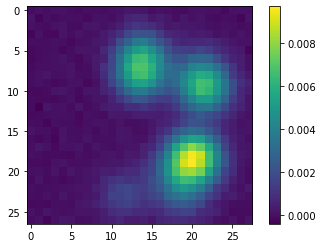

In [19]:
plt.imshow(video[:,:,0,0])
plt.colorbar()

In [6]:
type(positions)

torch.Tensor

In [7]:
positions[:,:,0][:,:,np.newaxis].shape

torch.Size([20, 3, 1])

In [8]:
positions.shape

torch.Size([20, 3, 10])

In [9]:
positions[0,:,0]

tensor([17.2985, 21.2046,  0.0000])

In [10]:
positions[:,:,np.newaxis][0,:,0]

tensor([[ 1.7299e+01,  1.7169e+01,  1.7153e+01,  1.7163e+01,  1.7282e+01,
          1.7330e+01,  1.7237e+01,  1.7204e+01,  1.6977e+01,  1.7022e+01],
        [ 2.1205e+01,  2.1091e+01,  2.1077e+01,  2.1167e+01,  2.1024e+01,
          2.1044e+01,  2.1045e+01,  2.1115e+01,  2.1043e+01,  2.1080e+01],
        [ 0.0000e+00,  4.5772e-03, -8.0972e-03, -1.4349e-02, -1.0588e-02,
         -1.0867e-02, -5.2809e-03, -1.8780e-03,  1.4154e-03,  2.3916e-03]])

In [13]:
type(positions[0,0,0].item())

float

In [16]:
type(video[0,0,0,0].item())

float